In [1]:
from typing import Tuple, Union, List
import numpy as np
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from scipy.ndimage.filters import gaussian_filter

import torch.nn as nn
from torch import Tensor
import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.models as models

from torchvision import transforms

import argparse

import scipy
import os
import cv2
import json
import imageio
import numpy as np
from PIL import Image

import matplotlib
from matplotlib import pyplot as plt

from tqdm import tqdm
from sklearn import metrics

/tmp/ipykernel_464849/2834367543.py:3: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom
/tmp/ipykernel_464849/2834367543.py:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
data_transform = transforms.Compose(
    [
        transforms.Resize(
            (224,224), interpolation=transforms.InterpolationMode.BICUBIC
        ),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

def transform_vision_data(image):
    """
    Input:
        image: An image read by opencv [w,h,c]
    Output:
        image: After preproccessing, is a tensor [c,w,h]
    """
    image = Image.fromarray(image)
    image = data_transform(image)
    return image

def preprocess_input(images):
    """
    Input:
        image: An image read by opencv [b,w,h,c]
    Output:
        outputs: After preproccessing, is a tensor [c,w,h]
    """
    outputs = []
    for image in images:
        image = Image.fromarray(image)
        image = data_transform(image)
        outputs.append(image)
    return torch.stack(outputs)

In [3]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [4]:
_CLAMP_NEG_ = False

def norm_cam(cam: Tensor):
    if _CLAMP_NEG_:
        cam = cam.clamp(min=0)
    BS, H, W = cam.size()
    cam = cam.view(BS, H*W)
    max_v = cam.max(dim=-1)[0].view(BS, 1)
    min_v = cam.min(dim=-1)[0].view(BS, 1)
    cam = (cam - min_v) / (max_v - min_v + 1e-8)
    cam = cam.view(BS, H, W)
    return cam

def gkern(ch, klen, ksig):
    inp = np.zeros((klen, klen))
    inp[klen//2, klen//2] = 1
    k = gaussian_filter(inp, ksig)
    kern = np.zeros((ch, ch, klen, klen))
    for i in range(ch):
        kern[i, i] = k
    return torch.from_numpy(kern.astype("float32"))

def gaussian_blur(img, klen, ksig):
    device = img.device
    ch = img.size(1)
    # get gkern
    kern = gkern(ch, klen, ksig).to(device)
    # compute gaussian blur
    img_out = nn.functional.conv2d(img, kern, padding=klen//2)
    return img_out

def batch_l1_dist(input1, input2=None):
    bs = input1.size(0)
    if input2 is None:
        diff = torch.abs(input1).view(bs, -1)
    else:
        diff = torch.abs(input1 - input2).view(bs, -1)
    return torch.sum(diff, dim=-1)

In [5]:
class SAM:
    def __init__(self, line_type, reduction, step=5, n_frag=5, klen=11, ksig=5, momen=None, **kwargs):
        self.step = step
        self.n_frag = n_frag
        self.line_pool = line_type
        self.reduction = reduction
        self.klen = klen
        self.ksig = ksig
        self.momen = momen

    def _check_state(self, line_type):
        if line_type in ["deletion"]:
            self.is_inverse = True
        elif line_type in ["insertion"]:
            self.is_inverse = False
        else:
            raise KeyError(f"Invalid input line-type: {line_type}!")

    def __call__(self, model: nn.Module, img: Tensor, layer_name: str) -> dict:
        # model preparation bs x C x H x W
        model.eval()

        # select class
        _, _, H, W = img.size()
        output = model(img) # bs x K
        pred = torch.argmax(output, dim=-1)

        # compute cam
        cam_list = []
        for line_type in self.line_pool:
            ref_point = self.generate_ref_point(img, line_type)
            cam = self.generate_cam(model, pred, img, ref_point, line_type)
            cam = self.postproc_cam(cam)
            cam_list.append(cam)
        cam = torch.stack(cam_list).sum(dim=0)

        return {
            "score": output,
            "cam": norm_cam(cam),
            "pred": pred
        }
    
    def postproc_cam(self, cam):
        if self.reduction == "sum":
            return cam
        elif self.reduction == "norm":
            return norm_cam(cam)
        else:
            raise KeyError(f"Invalid reduction type: {self.reduction}!")

    def generate_ref_point(self, img, line_type):
        if line_type == "deletion":
            return torch.zeros_like(img)
        elif line_type == "insertion":
            return torch.zeros_like(img)
            # return gaussian_blur(img, klen=self.klen, ksig=self.ksig)
        else:
            raise KeyError(f"Invalid input line-type: {line_type}!")

    def generate_cam(self, model, pred, img, ref_point, line_type):
        # set internal states
        self._check_state(line_type)
        BS, C, H, W = img.shape
        step = self.step
        
        # initiate variables
        cur_point = img.clone() if self.is_inverse else ref_point
        end_point = ref_point if self.is_inverse else img.clone()
        total_l1_dist = batch_l1_dist(cur_point, end_point)
        step_bound = total_l1_dist / self.n_frag
        cam = torch.zeros(BS, H, W).to(cur_point.device)

        # recursively build line integral
        grads = None
        # initiate selected_mask
        selected_mask = ~ torch.isclose(cur_point, end_point)
        selected_mask = torch.any(selected_mask, dim=1) # BS x H x W
        while torch.any(selected_mask):
            # compute batch_mask
            batch_mask = torch.any(selected_mask.view(BS, -1), dim=-1) # BS
            N = torch.sum(batch_mask)
            selected_mask = selected_mask[batch_mask]

            # obtain score
            sub_cur_point = cur_point[batch_mask] # N x C x H x W
            sub_cur_point.requires_grad_(True)
            # scores = model(sub_cur_point).softmax(-1) # N x K
            scores = model(sub_cur_point) # N x K
            scores = scores[torch.arange(N), pred[batch_mask]] # N x K

            # compute gradients
            actual_grads = autograd.grad(torch.sum(scores), sub_cur_point)[0] # N x C x H x W
            if (grads is not None) and (self.momen is not None):
                grads[batch_mask] = (self.momen * actual_grads + (1 - self.momen) * grads[batch_mask]).detach()
            else:
                grads = torch.empty_like(cur_point)
                grads[batch_mask] = actual_grads.detach()
            sub_grads = grads[batch_mask]

            with torch.no_grad():
                # compute direction
                delta_direc = end_point[batch_mask] - sub_cur_point.detach() # N x C x H x W
                projection = torch.sum(sub_grads * delta_direc, dim=1)  # N x H x W

                q = step / (H*W)
                if self.is_inverse:
                    projection[~ selected_mask] = float("inf")
                    cur_quantile = torch.quantile(projection.view(N, -1), q=q, dim=-1, interpolation="lower", keepdim=True) + 1e-6
                    update_mask = projection < cur_quantile[:, None]
                else:
                    projection[~ selected_mask] = float("-inf")
                    cur_quantile = torch.quantile(projection.view(N, -1), q=1-q, dim=-1, interpolation="higher", keepdim=True) - 1e-6
                    update_mask = projection > cur_quantile[:, None]

                # compute next position
                update_mask = update_mask.unsqueeze(1).expand(-1, C, -1, -1) # N x C x H x W
                move_full_step = delta_direc * update_mask # N x C x H x W
                move_l1_dist = batch_l1_dist(move_full_step) # N

                # adjust l1-distance when outranges
                is_outrange = move_l1_dist > step_bound[batch_mask]
                adjust_l1_ratio = step_bound[batch_mask] / (move_l1_dist + 1e-8)
                sub_cur_point = sub_cur_point.detach()
                move_full_step[is_outrange] *= adjust_l1_ratio[is_outrange, None, None, None]
                
                # update current position and cam
                cur_point[batch_mask] += move_full_step
                cam[batch_mask] += torch.sum(move_full_step * sub_grads, dim=1)

                # update selected_mask
                selected_mask = ~ torch.isclose(cur_point, end_point)
                selected_mask = torch.any(selected_mask, dim=1) # BS x H x W

                move_norm = torch.norm(move_full_step.view(N, -1), p=2, dim=-1)
                cur_p_norm = torch.norm(cur_point.view(BS, -1), p=2, dim=-1)

        cam = - cam if self.is_inverse else cam
        return cam

In [6]:
explainer = SAM(
    line_type = ["deletion", "insertion"],
    reduction = "sum",
    step=224 * 16, 
    n_frag=50, 
    klen=31, 
    ksig=5,
    monen = 0.5
)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Instantiate model
vis_model = models.resnet101(pretrained = True)
vis_model.eval()
vis_model.to(device)
print("load ResNet-101 model")

/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load ResNet-101 model


In [8]:
image_path = "examples/dog_image.jpg"
img = cv2.imread(image_path)
img = cv2.resize(img, (224,224))

data_input = transform_vision_data(img)

In [9]:
label = vis_model(data_input.unsqueeze(0).to(device)).argmax(-1)

In [10]:
cam = explainer(vis_model, data_input.unsqueeze(0).to(device), 'no_layer_name')

In [11]:
explanation = cam["cam"][0].cpu().numpy()

In [14]:
def perturbed(image, mask, rate = 0.5, mode = "insertion"):
    mask_flatten = mask.flatten()
    number = int(len(mask_flatten) * rate)
    
    if mode == "insertion":
        new_mask = np.zeros_like(mask_flatten)
        index = np.argsort(-mask_flatten)
        new_mask[index[:number]] = 1

        
    elif mode == "deletion":
        new_mask = np.ones_like(mask_flatten)
        index = np.argsort(mask_flatten)
        new_mask[index[:number]] = 0
    
    new_mask = new_mask.reshape((mask.shape[0], mask.shape[1], 1))
    
    perturbed_image = image * new_mask
    return perturbed_image.astype(np.uint8)

In [15]:
steps = 50
insertion_explanation_images = []
deletion_explanation_images = []
for i in range(1, steps+1):
    perturbed_rate = i / steps
    insertion_explanation_images.append(perturbed(img, explanation, rate = perturbed_rate, mode = "insertion"))
    deletion_explanation_images.append(perturbed(img, explanation, rate = perturbed_rate, mode = "deletion"))

In [16]:
device = "cpu"
vis_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
insertion_explanation_images_input = preprocess_input(
    np.array(insertion_explanation_images)
).to(device)
deletion_explanation_images_input = preprocess_input(
    np.array(deletion_explanation_images)
).to(device)

In [18]:
insertion_explanation_images_input_results = vis_model(insertion_explanation_images_input)
deletion_explanation_images_input_results = vis_model(deletion_explanation_images_input)

In [19]:
json_file = {}
json_file["consistency_score"] = insertion_explanation_images_input_results.softmax(-1)[:,label[0]].cpu().tolist()
json_file["collaboration_score"] = deletion_explanation_images_input_results.softmax(-1)[:,label[0]].cpu().tolist()

In [20]:
def visualization(image, attribution_map, saved_json_file, vis_image, index=None):
    
    insertion_ours_images = []
    # deletion_ours_images = []

    insertion_image = image - image
    insertion_ours_images.append(insertion_image)
    # deletion_ours_images.append(image - insertion_image)
    for i in range(1, len(saved_json_file["consistency_score"])+1):
        insertion_ours_images.append(
            perturbed(image, attribution_map, rate = i/(len(saved_json_file["consistency_score"])), mode = "insertion"))
    
    insertion_ours_images_input_results = np.array([saved_json_file["collaboration_score"][-1]] + saved_json_file["consistency_score"])

    if index == None:
        ours_best_index = np.argmax(insertion_ours_images_input_results)
    else:
        ours_best_index = index
    x = [i/len(saved_json_file["collaboration_score"]) for i in range(0, len(insertion_ours_images_input_results))]
    # i = len(x)

    fig, [ax1, ax2, ax3] = plt.subplots(1,3, gridspec_kw = {'width_ratios':[1, 1, 1.5]}, figsize=(30,8))
    ax1.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Attribution Map', fontsize=54)
    ax1.set_facecolor('white')
    ax1.imshow(vis_image[...,::-1].astype(np.uint8))
    
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(True)
    ax2.yaxis.set_visible(False)
    ax2.set_title('Searched Region', fontsize=54)
    ax2.set_facecolor('white')
    ax2.set_xlabel("Highest conf. {:.4f}".format(insertion_ours_images_input_results.max()), fontsize=44)
    ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    ax3.set_xlim((0, 1))
    ax3.set_ylim((0, 1))
    
    ax3.set_ylabel('Recognition Score', fontsize=44)
    ax3.set_xlabel('Percentage of image revealed', fontsize=44)
    ax3.tick_params(axis='both', which='major', labelsize=36)

    x_ = x#[:i]
    ours_y = insertion_ours_images_input_results#[:i]
    ax3.plot(x_, ours_y, color='dodgerblue', linewidth=3.5)  # draw curve
    ax3.set_facecolor('white')
    ax3.spines['bottom'].set_color('black')
    ax3.spines['bottom'].set_linewidth(2.0)
    ax3.spines['top'].set_color('none')
    ax3.spines['left'].set_color('black')
    ax3.spines['left'].set_linewidth(2.0)
    ax3.spines['right'].set_color('none')

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    ax3.scatter(x_[-1], ours_y[-1], color='dodgerblue', s=54)  # Plot latest point
    # 在曲线下方填充淡蓝色
    ax3.fill_between(x_, ours_y, color='dodgerblue', alpha=0.1)

    kernel = np.ones((3, 3), dtype=np.uint8)
    # ax3.plot([x_[ours_best_index], x_[ours_best_index]], [0, 1], color='red', linewidth=3.5)  # 绘制红色曲线
    ax3.axvline(x=x_[ours_best_index], color='red', linewidth=3.5)  # 绘制红色垂直线

    # Ours
    mask = (image - insertion_ours_images[ours_best_index]).mean(-1)
    mask[mask>0] = 1

    if ours_best_index != 0:
        dilate = cv2.dilate(mask, kernel, 3)
        # erosion = cv2.erode(dilate, kernel, iterations=3)
        # dilate = cv2.dilate(erosion, kernel, 2)
        edge = dilate - mask
        # erosion = cv2.erode(dilate, kernel, iterations=1)

    image_debug = image.copy()

    image_debug[mask>0] = image_debug[mask>0] * 0.5
    if ours_best_index != 0:
        image_debug[edge>0] = np.array([0,0,255])
    ax2.imshow(image_debug[...,::-1])
    
    auc = metrics.auc(x, insertion_ours_images_input_results)
    ax3.set_title('Insertion {:.4f}'.format(auc), fontsize=54)

In [21]:
def gen_cam(image, mask):
    """
    Generate heatmap
        :param image: [H,W,C]
        :param mask: [H,W],range 0-1
        :return: tuple(cam,heatmap)
    """
    # Read image
    # image = cv2.resize(cv2.imread(image_path), (224,224))
    # mask->heatmap
    heatmap = cv2.applyColorMap(np.uint8(mask*255), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap)

    # merge heatmap to original image
    cam = 0.5*heatmap + 0.5*np.float32(image)
    return cam, (heatmap).astype(np.uint8)

In [22]:
im, heatmap = gen_cam(img, explanation)

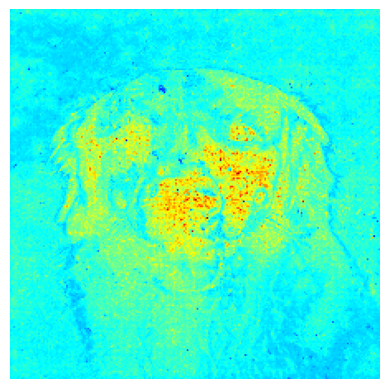

In [23]:
imshow(heatmap)

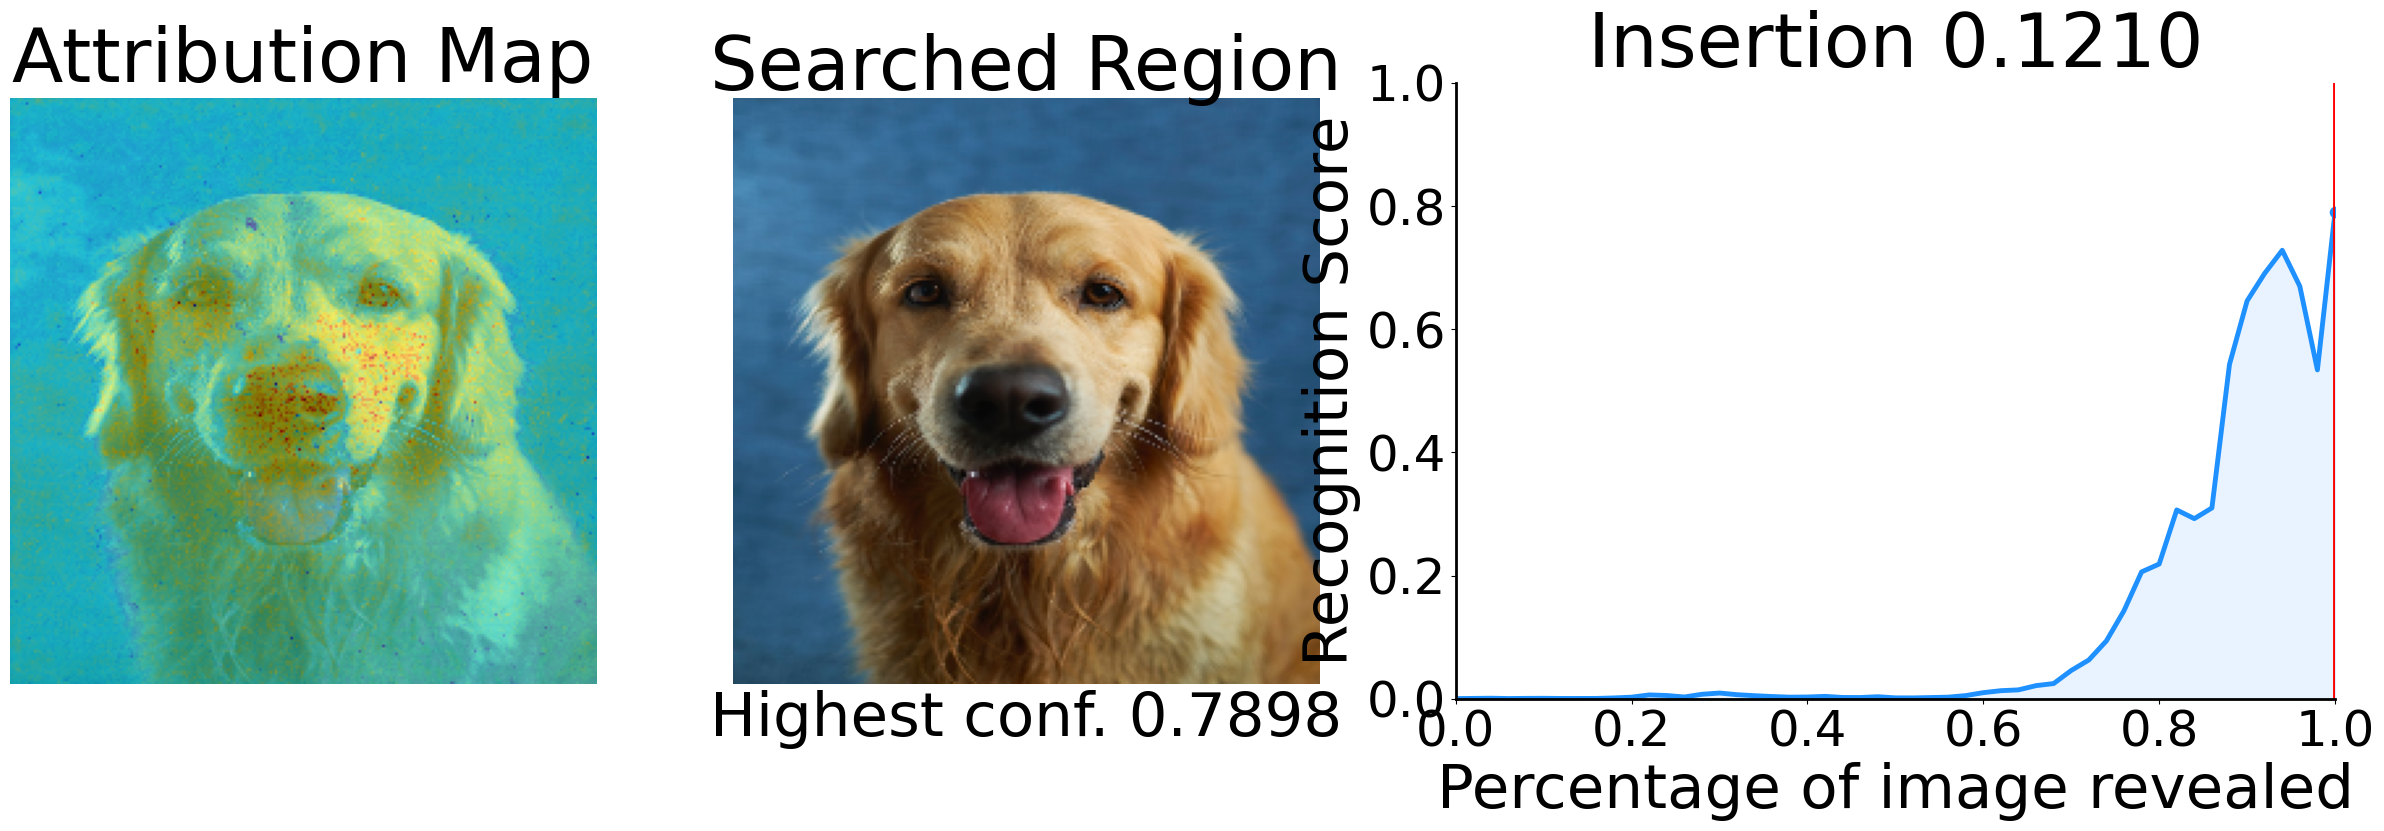

In [24]:
visualization(img, explanation, json_file, im)